In [1]:
# Installing `caer` and `canaro` since they don't come pre-installed
# !pip install --upgrade caer canaro

In [2]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc
#pylint:disable=no-member (Removes linting problems with cv)

In [3]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'./dataset/simpsons_dataset'

In [4]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [5]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [6]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.016568422317504883s
[INFO] At 1000 files
[INFO] 1454 files found in 0.005518198013305664s
[INFO] At 1000 files
[INFO] 1452 files found in 0.008312702178955078s
[INFO] At 1000 files
[INFO] 1354 files found in 0.006051778793334961s
[INFO] At 1000 files
[INFO] 1342 files found in 0.006995201110839844s
[INFO] At 1000 files
[INFO] 1291 files found in 0.0069997310638427734s
[INFO] At 1000 files
[INFO] 1206 files found in 0.006566524505615234s
[INFO] At 1000 files
[INFO] 1194 files found in 0.006411075592041016s
[INFO] At 1000 files
[INFO] 1193 files found in 0.004998445510864258s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0034563541412353516s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 20s


In [7]:
# Number of training samples
len(train)

13811

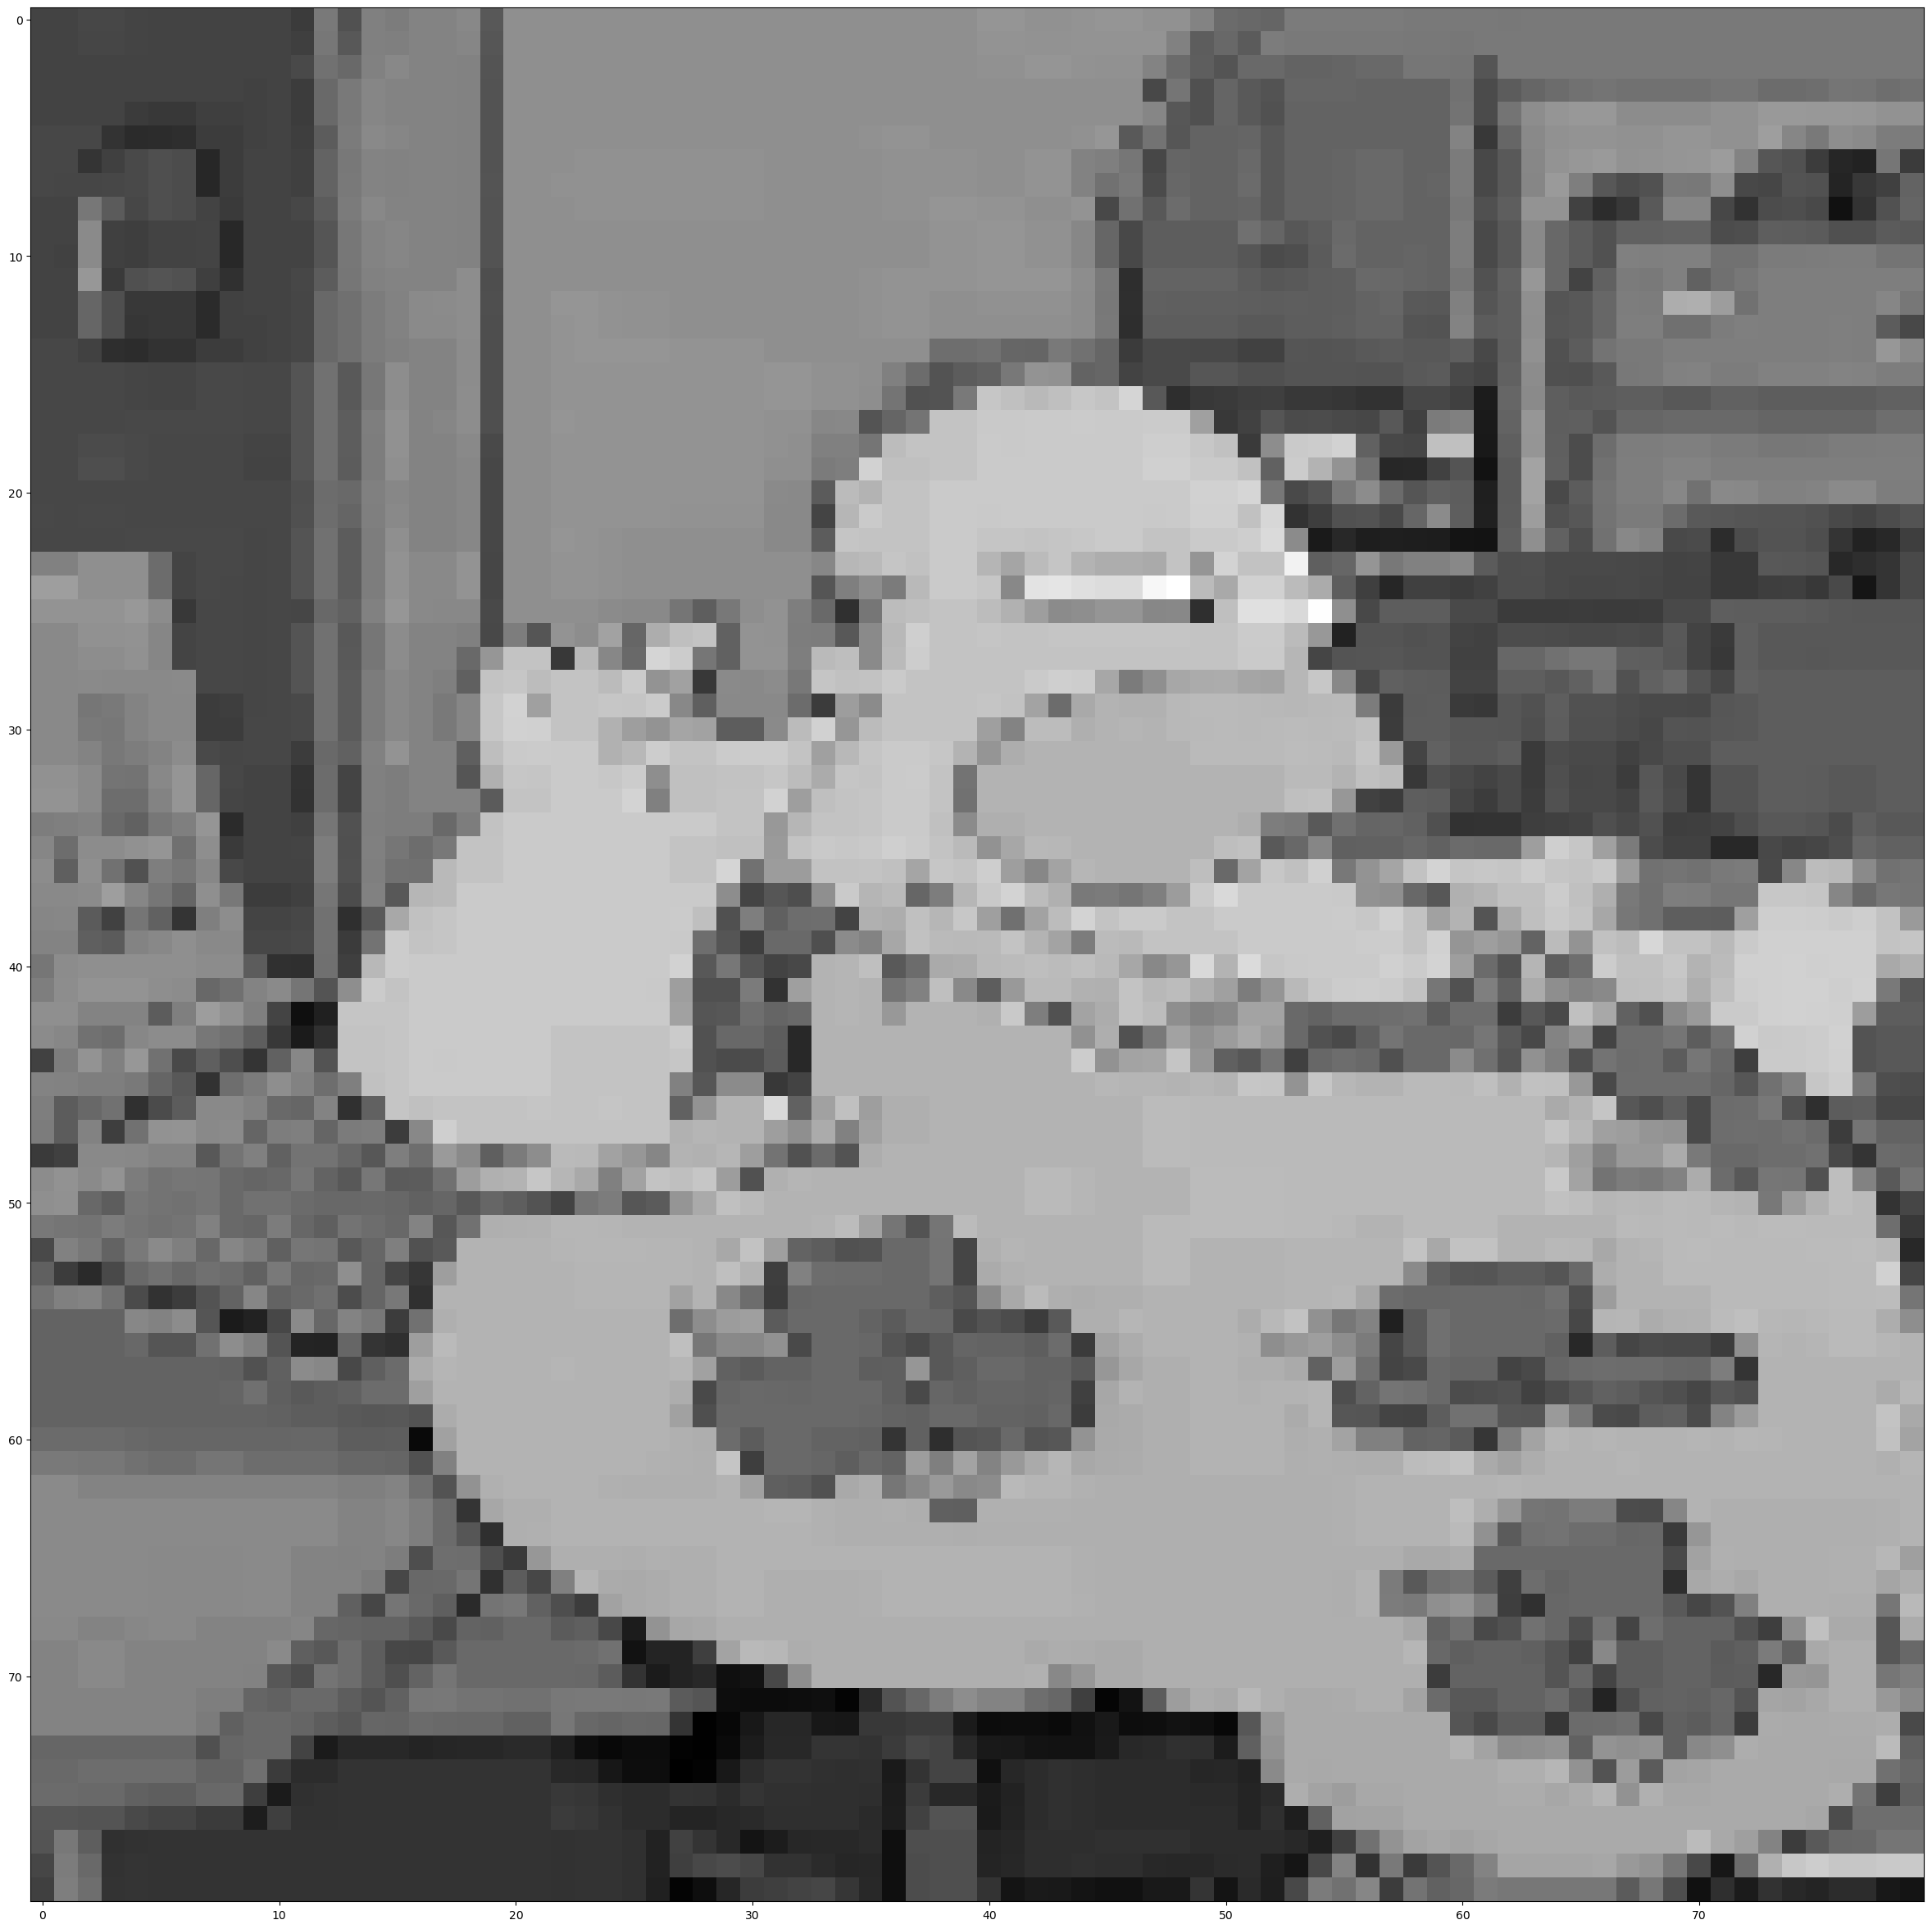

In [8]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [9]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [10]:
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

In [11]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [12]:
del train
del featureSet
del labels 
gc.collect()

0

In [13]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 60

In [14]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [15]:
# Create our model (returns a compiled model)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

output_dim=10

w, h = IMG_SIZE[:2]

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h,channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))


c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 80, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 78, 78, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,591,274 (67.11 MB)

 Trainable params: 17,591,274 (67.11 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(learning_rate=0.001, decay=1e-7, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    'best_model.keras',         # Path to save the model
    monitor='val_loss',         # Metric to monitor (e.g., 'val_loss', 'val_accuracy')
    save_best_only=True,        # Only saves the model if the current validation loss is the best
    save_weights_only=False,    # Whether to save the full model (True saves only weights)
    verbose=1                   # Print messages when saving the model
)


In [20]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule), checkpoint_callback]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/60


c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.1485 - loss: 0.3866
Epoch 1: val_loss improved from inf to 0.33469, saving model to best_model.keras


c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


345/345 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.1486 - loss: 0.3865 - val_accuracy: 0.1621 - val_loss: 0.3347 - learning_rate: 0.0100
Epoch 2/60
  1/345 ━━━━━━━━━━━━━━━━━━━━ 1:35 277ms/step - accuracy: 0.1562 - loss: 0.3247
Epoch 2: val_loss improved from 0.33469 to 0.33426, saving model to best_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1562 - loss: 0.3247 - val_accuracy: 0.1621 - val_loss: 0.3343 - learning_rate: 0.0100
Epoch 3/60
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1611 - loss: 0.3242
Epoch 3: val_loss improved from 0.33426 to 0.33288, saving model to best_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - accuracy: 0.1611 - loss: 0.3242 - val_accuracy: 0.1621 - val_loss: 0.3329 - learning_rate: 0.0100
Epoch 4/60
  1/345 ━━━━━━━━━━━━━━━━━━━━ 1:17 226ms/step - accuracy: 0.1250 - loss: 0.3245
Epoch 4: val_loss did not improve from 0.33288
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1250 - loss: 0.3245 - val_acc

In [23]:
import tensorflow as tf
model.save('model.h5')

In [25]:
best_model = tf.keras.models.load_model('best_model.keras')


In [ ]:
# If Epoch 50 The accuracy will definetly increase

In [ ]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

## Testing

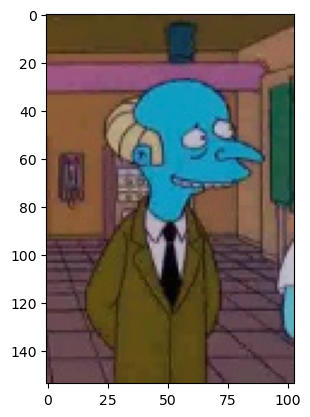

In [ ]:
test_path = r'./dataset/kaggle_simpson_testset/kaggle_simpson_testset/charles_montgomery_burns_0.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [ ]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [ ]:
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


In [ ]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

lisa_simpson
